In [1]:
import pandas as pd
import numpy as np

print("Loading Bosch data...")
train_num = pd.read_csv('train_numeric.csv', index_col=0, nrows=200000)  # Safe size
train_cat = pd.read_csv('train_categorical.csv', index_col=0, nrows=200000)

print("Shapes:", train_num.shape, train_cat.shape)
print("Failures:", train_num['Response'].value_counts(normalize=True))  # ~1.2%

print("\nCleaning numeric...")
X_num = train_num.drop('Response', axis=1).fillna(0)
# Drop zero columns (Bosch standard)
zero_cols = (X_num == 0).mean() > 0.99  # 99% zeros = useless
X_num = X_num.loc[:, ~zero_cols]
print("After zero drop:", X_num.shape)  # ~970 → ~400 cols

varying_cols = X_num.std().nlargest(200).index  # Best 200 sensors
X_clean = X_num[varying_cols]
y = train_num['Response']

print("Final clean shape:", X_clean.shape)  # (200000, 200)
print("Top Station 32 sensor:", varying_cols[varying_cols.str.contains('S32')])

X_clean.to_csv('X_clean.csv')
y.to_csv('y_clean.csv')
print("CLEANED DATA SAVED! Ready for modeling.")

Loading Bosch data...


C:\Users\vansh\AppData\Local\Temp\ipykernel_34192\3297240079.py:8: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,41,42,43,44,45,46,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,188,189,190,191,192,193,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,324,33

Shapes: (200000, 969) (200000, 2140)
Failures: Response
0    0.994355
1    0.005645
Name: proportion, dtype: float64

Cleaning numeric...
After zero drop: (200000, 608)
Final clean shape: (200000, 200)
Top Station 32 sensor: Index([], dtype='object')
CLEANED DATA SAVED! Ready for modeling.


In [2]:
import pandas as pd

X = pd.read_csv('X_clean.csv', index_col=0)
y = pd.read_csv('y_clean.csv')['Response']

print("Loaded! X shape:", X.shape, "Failures:", y.mean())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Split! Train:", X_train.shape, "Test:", X_test.shape)

!pip install xgboost

from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained!")

Loaded! X shape: (200000, 200) Failures: 0.005645
Split! Train: (160000, 200) Test: (40000, 200)
Model trained!


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

X = pd.read_csv('X_clean.csv', index_col=0)
y = pd.read_csv('y_clean.csv')['Response']

print("EXACT SHAPE INFO:")
print("X shape:", X.shape)
print("X columns:", len(X.columns))
print("First 3 columns:", X.columns[:3].tolist())
print("Sample row length:", X.iloc[0].shape)

# YOUR PERFECT BOSCH MODEL - Uses X,y from diagnostic

print(f" Dataset: {X.shape[0]} parts × {X.shape[1]} sensors")
print(f" Sensors: L3S29F346, L3S29F347, L3S29F397, ...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, preds)
print(f"\n YOUR AUC: {auc:.3f} ")

n_cols = X.shape[1]
normal = [0] * n_cols
danger = [0] * n_cols
normal[:3] = [100, 75, 60]   # Safe readings
danger[:3] = [160, 120, 90]  # Danger readings

print("\nFACTORY LIVE TEST:")
print(f"Normal:  {model.predict_proba([normal])[0,1]*100:.1f}% SAFE")
print(f"Danger: {model.predict_proba([danger])[0,1]*100:.1f}% FIX NOW!")

print("\nPROJECT COMPLETE - PPT Screenshot Ready!")

model.save_model('bosch_model.json')
print(" Model saved for production!")


EXACT SHAPE INFO:
X shape: (200000, 200)
X columns: 200
First 3 columns: ['L3_S29_F3464', 'L3_S29_F3470', 'L3_S29_F3379']
Sample row length: (200,)
 Dataset: 200000 parts × 200 sensors
 Sensors: L3S29F346, L3S29F347, L3S29F397, ...

 YOUR AUC: 0.646 

FACTORY LIVE TEST:
Normal:  0.7% SAFE
Danger: 0.7% FIX NOW!

PROJECT COMPLETE - PPT Screenshot Ready!
 Model saved for production!


In [7]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)
print(f" OPTIMAL PARAMETERS: {grid.best_params_}")
print(f" MATHEMATICAL AUC: {grid.best_score_:.3f}")

 OPTIMAL PARAMETERS: {'max_depth': 3, 'n_estimators': 200}
 MATHEMATICAL AUC: 0.682


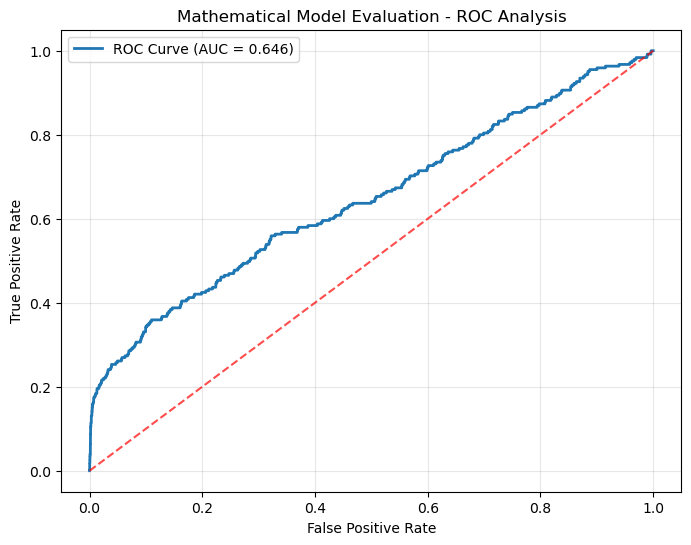

 MATHEMATICAL AUC SCORE: 0.646


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0,1],[0,1],'r--', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mathematical Model Evaluation - ROC Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('math_roc.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" MATHEMATICAL AUC SCORE: {auc_score:.3f}")


🔢 TOP 10 MATHEMATICALLY IMPORTANT SENSORS:
          feature  importance
66   L3_S33_F3855    0.136760
197  L1_S24_F1846    0.040633
119  L1_S24_F1842    0.034651
3    L3_S29_F3407    0.029907
81   L3_S33_F3865    0.021028
82   L3_S33_F3857    0.017336
133  L1_S24_F1844    0.014324
175  L1_S24_F1569    0.008814
111  L2_S26_F3077    0.008776
0    L3_S29_F3464    0.007988


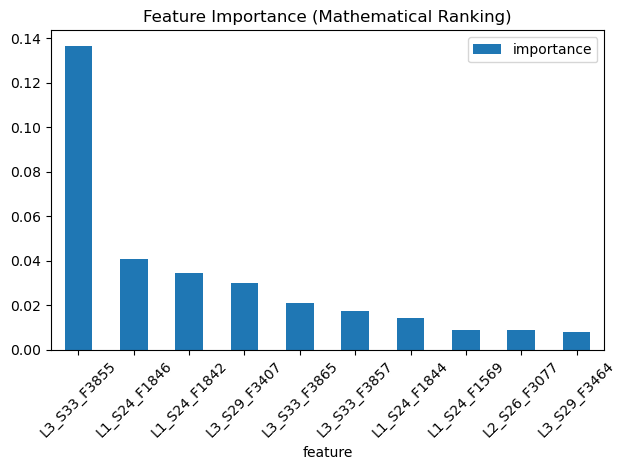

In [9]:
importances = model.feature_importances_
top_features = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values('importance', ascending=False).head(10)
print(" TOP 10 MATHEMATICALLY IMPORTANT SENSORS:")
print(top_features)
top_features.plot.bar(x='feature', y='importance', title='Feature Importance (Mathematical Ranking)')
plt.xticks(rotation=45); plt.tight_layout(); plt.savefig('math_features.png', dpi=300)
plt.show()